# import libraries and data 

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.shape

(20972, 9)

In [4]:
data.head(5)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


# preprocces of data 

In [5]:
data.columns = [i.lower().replace(' ','_') for i in data.columns]

In [6]:
data.head(1)

,id,title,abstract,computer_science,physics,mathematics,statistics,quantitative_biology,quantitative_finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0


In [7]:
data.shape

(20972, 9)

In [8]:
data.isnull().sum()

id                      0
title                   0
abstract                0
computer_science        0
physics                 0
mathematics             0
statistics              0
quantitative_biology    0
quantitative_finance    0
dtype: int64

In [9]:
data.duplicated().sum()

0

# we have to change the outpout to a single column ! : 

In [10]:
output = data.drop(columns=['id','title','abstract']).values

In [11]:
clas = []
sub = data[['computer_science','physics','mathematics','statistics','quantitative_biology','quantitative_finance']].values
for i in sub:
    x = i.argmax(0)
    clas.append(x)



data['class'] = clas
data.drop(columns=['computer_science','physics','mathematics','statistics','quantitative_biology','quantitative_finance'],inplace=True)








In [12]:
df = data

# combine abstract with title 

In [13]:
df.head(2)

,id,title,abstract,class
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,0


In [14]:
text = []


vals = df[['title','abstract']].values


for i in vals:
    text.append(str(i[0])+str(i[1]))

df['text'] = text

In [15]:
len(vals)

20972

In [16]:
# just a check
print(len(df.loc[df['id'] == 1,'title'].values[0]))
print(len(df.loc[df['id'] == 1,'abstract'].values[0]))
print(len(df.loc[df['id'] == 1,'text'].values[0]))

43
1912
1955


### everithing is fine we can proceed 

In [17]:
df.drop(columns=['title','abstract','id'],inplace=True)

In [18]:
df = df[['text','class']]

In [19]:
df.head(3)

,text,class
0,Reconstructing Subject-Specific Effect Maps P...,0
1,Rotation Invariance Neural Network Rotation i...,0
2,Spherical polyharmonics and Poisson kernels fo...,2


# independed feature

In [20]:
x = df['text'].values

In [21]:
# clean x

import re 

clean = re.compile('(?i)[^0-9a-z\s]')


x = [clean.sub('',text) for text in x]

In [22]:
x[0]

'Reconstructing SubjectSpecific Effect Maps  Predictive models allow subjectspecific inference when analyzing disease\nrelated alterations in neuroimaging data Given a subjects data inference can\nbe made at two levels global ie identifiying condition presence for the\nsubject and local ie detecting condition effect on each individual\nmeasurement extracted from the subjects data While global inference is widely\nused local inference which can be used to form subjectspecific effect maps\nis rarely used because existing models often yield noisy detections composed of\ndispersed isolated islands In this article we propose a reconstruction\nmethod named RSM to improve subjectspecific detections of predictive\nmodeling approaches and in particular binary classifiers RSM specifically\naims to reduce noise due to sampling error associated with using a finite\nsample of examples to train classifiers The proposed method is a wrappertype\nalgorithm that can be used with different binary classif

# depended feature 

In [23]:
y = df['class'].values

# remove stop words

In [25]:
from nltk.corpus import stopwords
stop  = stopwords.words("english")


def remove_stop(sent):
    text = ' '.join([word for word in sent.split() if word not in stop])
    return text

In [26]:
text = []
for i in x:
    new = remove_stop(i)
    text.append(new)
    

In [27]:
x = np.array(text)

# lemmatizing words

In [28]:
from nltk.stem import WordNetLemmatizer

In [29]:
lemmatizer = WordNetLemmatizer()
 

In [30]:
def lematize(sent):
    text = ' '.join([lemmatizer.lemmatize(word) for word in sent.split()])
    return text 

In [31]:
text = []
for i in x:
    new = lematize(i)
    text.append(new)
    
x = np.array(text)    


# split in train and test 

In [32]:
from sklearn.model_selection import train_test_split as tt
x_train,x_test,y_train,y_test = tt(x,y,test_size=0.2)

# Tokenize the words

In [36]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [40]:
token = Tokenizer(num_words=40000,oov_token = 'oov_tok')

In [41]:
token.fit_on_texts(x_train)

In [42]:
len(token.word_index)

50959

In [43]:
x = np.argmax(x_train)
size_ = len(x_train[x])
size_

1330

# make sequences and pad them 

In [44]:
train_sequences = token.texts_to_sequences(x_train)
training_padded = pad_sequences(train_sequences, maxlen=size_, padding='post', truncating='post')

In [45]:
test_sequences = token.texts_to_sequences(x_test)
test_padded = pad_sequences(test_sequences, maxlen=size_, padding='post', truncating='post')

# first lets try build our own tensorflow model

###  create the input that the tensorflow expects

In [46]:
train_x = np.array(training_padded)
train_y = np.array(y_train)


test_x = np.array(test_padded)
test_y = np.array(y_test)

In [47]:
from tensorflow.keras.utils import to_categorical


train_y = to_categorical(train_y,num_classes=6)
test_y = to_categorical(test_y,num_classes=6)

### save best weights at training 

In [48]:

import tensorflow as tf

cp_callback = tf.keras.callbacks.ModelCheckpoint(monitor='vall_loss',
    filepath='model_best.h5',
                                                 save_weights_only=True,
                                                 verbose=1)

### model


In [49]:


from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import *

In [50]:
model = Sequential()

model.add(Embedding(50000,output_dim=20,input_length=size_))
model.add(GlobalAveragePooling1D())
model.add(Dense(20,'relu',kernel_regularizer='l1_l2'))
model.add(BatchNormalization())
model.add(Dense(6,'softmax'))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1330, 20)          1000000   
                                                                 
 global_average_pooling1d (  (None, 20)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 20)                420       
                                                                 
 batch_normalization (Batch  (None, 20)                80        
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 6)                 126       
                                                                 
Total params: 1000626 (3.82 MB)
Trainable params: 10005

In [51]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [52]:
hist = model.fit(train_x,train_y,epochs=10,validation_data=(test_x,test_y),callbacks=[cp_callback])

Epoch 1/10


525/525 [==============================] - ETA: 0s - loss: 1.4479 - accuracy: 0.6690
Epoch 1: saving model to model_best.h5
525/525 [==============================] - 12s 19ms/step - loss: 1.4479 - accuracy: 0.6690 - val_loss: 1.2452 - val_accuracy: 0.6360
Epoch 2/10
525/525 [==============================] - ETA: 0s - loss: 0.8085 - accuracy: 0.7873
Epoch 2: saving model to model_best.h5
525/525 [==============================] - 10s 19ms/step - loss: 0.8085 - accuracy: 0.7873 - val_loss: 0.8364 - val_accuracy: 0.7709
Epoch 3/10
522/525 [============================>.] - ETA: 0s - loss: 0.6969 - accuracy: 0.8039
Epoch 3: saving model to model_best.h5
525/525 [==============================] - 9s 17ms/step - loss: 0.6965 - accuracy: 0.8040 - val_loss: 1.3877 - val_accuracy: 0.5190
Epoch 4/10
523/525 [============================>.] - ETA: 0s - loss: 0.6176 - accuracy: 0.8191
Epoch 4: saving model to model_best.h5
525/525 [==============================] - 10s 20ms/step - l

In [53]:
model.load_weights('model_best.h5')

### predictions and metrics 

In [100]:
preds = model.predict(test_x)

132/132 [==============================] - 1s 4ms/step


### a function to return the argmax of preds:


In [101]:
def ys(x):
    y = []
    for i in x:
        a = np.argmax(i)
        y.append(a)
    return y 
    

In [102]:
y_pred = ys(preds)
y_test = ys(test_y)

In [89]:
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,hamming_loss

### a function for metrics  : 

In [107]:
def metrics(y_pred,y_test = y_test):
    ac = accuracy_score(y_pred,y_test)
    f1 = f1_score(y_pred,y_test,average='micro')
    hloss = hamming_loss(y_pred,y_test)
    print(f'accuracy { ac}  f1 score {f1}   hammingloss {hloss}')



metrics(y_pred)

accuracy 0.6557806912991657  f1 score 0.6557806912991657   hammingloss 0.34421930870083434


<Axes: >

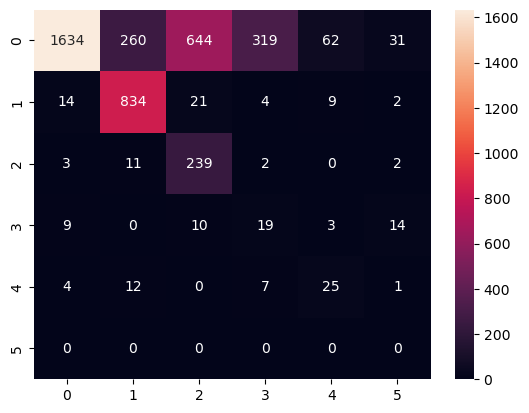

In [91]:
import seaborn as sns

cm  = confusion_matrix(y_pred,y_test)

sns.heatmap(cm,annot=True,fmt='.0f')

# now lets use a  pretrainded model SciBERT: A Pretrained Language Model for Scientific Text

In [32]:
#make y a good input

from tensorflow.keras.utils import to_categorical


y = to_categorical(y,num_classes=6)


In [33]:
x = [str(i) for i in x]

In [34]:
import transformers


seq_len = 512
num_samples = len(x)
seq_len,num_samples

(512, 20972)

In [35]:
from transformers import BertTokenizer


In [36]:
tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')

In [37]:
# fit x to tokenizer

tokens = tokenizer(x,max_length=seq_len,truncation=True,padding='max_length',add_special_tokens=True,return_tensors='np')

In [38]:
# see the keys

tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [39]:
input_ids = tokens['input_ids']

In [40]:
attention_mask = tokens['attention_mask']

In [41]:
input_ids.shape,attention_mask.shape

((20972, 512), (20972, 512))

In [42]:
# make it a tf datset

import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((input_ids,attention_mask,y))

In [43]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(6,), dtype=tf.float32, name=None))>

In [44]:
#make the input dict:


def dictt(input_ids,attention_mask,y):
    return {'input_ids':input_ids,'attention_mask':attention_mask
            },y


dataset = dataset.map(dictt)

In [45]:
# prepare the training

batch_s = 16

dataset = dataset.shuffle(10000)

dataset = dataset.batch(batch_s,drop_remainder=False)

In [46]:
#split in train test 
split = 0.8

train_size = train_size = int((input_ids.shape[0]/batch_s)* split )


train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)

# create the model 

In [47]:
from transformers import TFAutoModel 


model = TFAutoModel.from_pretrained('allenai/scibert_scivocab_uncased',from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

# make the model suitable to our data 

In [48]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model






# input layers 
input_ids_layer = tf.keras.layers.Input(shape=(512,),name='input_ids',dtype='int32')

mask_layer = tf.keras.layers.Input(shape=(512,),name='attention_mask',dtype='int32')


# transformer layer
embedings = model.bert(input_ids_layer,attention_mask =mask_layer )[1]

#classifier 

dense1 = Dense(500,activation='relu')(embedings)
out = Dense(6,activation='softmax')(dense1)





model = Model(inputs=[input_ids_layer,mask_layer],outputs = out)

In [49]:
# make bert layer not trainable
model.layers[2].trainable=False

In [50]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1099184   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   64         'attention_mask[0][0]']      
                             hidden_state=(None, 512, 7                                       

In [51]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer,loss=loss,metrics=[acc])

In [53]:
hist = model.fit(train_ds,validation_data=test_ds,epochs=4)

Epoch 1/4
1048/1048 [==============================] - 27991s 27s/step - loss: 0.8176 - accuracy: 0.7410 - val_loss: 0.6056 - val_accuracy: 0.7938
Epoch 2/4
1048/1048 [==============================] - 27986s 27s/step - loss: 0.6508 - accuracy: 0.7718 - val_loss: 0.5964 - val_accuracy: 0.7847
Epoch 3/4
1048/1048 [==============================] - 28027s 27s/step - loss: 0.6233 - accuracy: 0.7810 - val_loss: 0.5628 - val_accuracy: 0.7971
Epoch 4/4
1048/1048 [==============================] - 28064s 27s/step - loss: 0.6036 - accuracy: 0.7869 - val_loss: 0.5694 - val_accuracy: 0.7952


In [54]:
preds2 = model.predict(test_ds)

263/263 [==============================] - 4059s 15s/step


In [129]:
actuals = []
for i in test_ds.unbatch().take(4204):
    x = i
    actuals.append(np.argmax(x[1]))
    
    

In [130]:
predicted = [np.argmax(i) for i in preds2]

In [131]:
import seaborn as sns
from sklearn.metrics import confusion_matrix 

<Axes: >

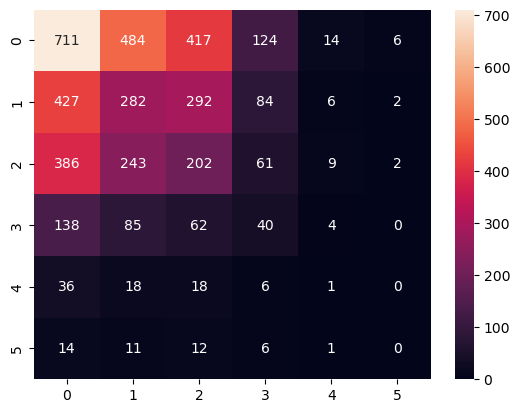

In [133]:
cm = confusion_matrix(actuals,predicted)
sns.heatmap(cm,annot=True,fmt='.0f')

In [143]:
# save predictions 
with open('predicted.txt','w') as f:
    for i in predicted:
        f.write(str(i))
f.close()

In [144]:
# save predictions 
with open('actuals.txt','w') as f:
    for i in actuals:
        f.write(str(i))
f.close()